<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a> | <a href="https://chat.vlm.run"><b>Chat</b></a>
</p>
</div>

# VLM Run Orion - 3x3 Storyboard Image Generation

This notebook demonstrates how to use [VLM Run Orion's](https://vlm.run/orion) image generation capabilities to create professional 3x3 storyboard grids from story prompts. Each storyboard contains 9 sequential scenes arranged in a grid layout, perfect for visualizing narratives, film concepts, or sequential storytelling.

For more details on the API, see the [Agent API docs](https://docs.vlm.run/agents/introduction).

## Prerequisites

- Python 3.10+
- VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))
- VLM Run Python Client with OpenAI extra `vlmrun[openai]`


## Setup

First, install the required packages and configure the environment.


In [4]:
# Install required packages
%pip install vlmrun[openai] --upgrade --quiet
%pip install cachetools pillow requests numpy --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
import getpass

VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass("Enter your VLM Run API key: ")


## Initialize the VLM Run Client

We use the OpenAI-compatible chat completions interface through the VLM Run SDK.


In [6]:
from vlmrun.client import VLMRun

BASE_URL = os.getenv("VLMRUN_BASE_URL", "https://agent.vlm.run/v1")
client = VLMRun(api_key=VLMRUN_API_KEY, base_url=BASE_URL)
print("VLM Run client initialized successfully!")
print(f"Base URL: {BASE_URL}")


VLM Run client initialized successfully!
Base URL: https://agent.vlm.run/v1


## Response Models

We define Pydantic models for structured outputs. The response will include an image reference that can be retrieved via the `client.artifacts.get` method.


In [7]:
from pydantic import BaseModel, Field
from vlmrun.types import ImageRef


class StoryboardResponse(BaseModel):
    """Response containing the generated 3x3 storyboard image."""
    image: ImageRef = Field(..., description="The generated 3x3 storyboard image with 9 sequential scenes")

print("Response models defined successfully!")


Response models defined successfully!


## Helper Functions

We create helper functions to simplify making chat completion requests with structured outputs.


In [8]:
import hashlib
import json
from typing import Any, Type, TypeVar

import cachetools
from IPython.display import HTML
from vlmrun.common.image import encode_image
from PIL import Image


T = TypeVar('T', bound=BaseModel)


def display(images: Image.Image | list[Image.Image], texts: list[str] | None = None, width: int = 600):
    """Display images in a notebook-friendly format."""
    if isinstance(images, Image.Image):
        images = [images]
    if texts is None:
        texts = [None] * len(images)
    elif isinstance(texts, str):
        texts = [texts]
    elif len(texts) != len(images):
        raise ValueError("`texts` must be a list of the same length as `images`")

    imgs_html = ""
    for image, text in zip(images, texts):
        W, H = image.size
        if W > width:
            H = int(H * width / W)
            W = width
            image = image.resize((W, H))
        im_bytes = encode_image(image, format="JPEG")
        imgs_html += f"<div style='display:inline-block; margin:5px; text-align:center'>"
        imgs_html += f"<img src='{im_bytes}' style='width:{width}px; border-radius:6px'>"
        if text:
            imgs_html += f"<div style='font-size:12px; color:#666; margin-top:5px'>{text}</div>"
        imgs_html += f"</div>"
    return HTML(f"<div style='display:flex; flex-wrap:wrap'>{imgs_html}</div>")


def custom_key(prompt: str, response_model: Type[T] | None = None, model: str = "vlmrun-orion-1:auto"):
    """Custom key for caching chat_completion."""
    response_key = hashlib.sha256(json.dumps(response_model.model_json_schema(), sort_keys=True).encode()).hexdigest() if response_model else ""
    return (prompt, response_key, model)


@cachetools.cached(cache=cachetools.TTLCache(maxsize=100, ttl=3600), key=custom_key)
def chat_completion(
    prompt: str,
    response_model: Type[T] | None = None,
    model: str = "vlmrun-orion-1:auto"
) -> tuple[BaseModel, str]:
    """
    Make a chat completion request with structured output for storyboard generation.

    Args:
        prompt: The storyboard generation prompt describing 9 sequential scenes
        response_model: Pydantic model for structured output
        model: Model to use (default: vlmrun-orion-1:auto)

    Returns:
        Tuple of (parsed response model, session_id)
    """
    content = [{"type": "text", "text": prompt}]

    kwargs = {
        "model": model,
        "messages": [{"role": "user", "content": content}]
    }

    if response_model:
        kwargs["response_format"] = {
            "type": "json_schema",
            "schema": response_model.model_json_schema()
        }

    response = client.agent.completions.create(**kwargs)
    response_text = response.choices[0].message.content
    session_id = response.session_id

    if response_model:
        result = response_model.model_validate_json(response_text)
        return result, session_id

    return response_text, session_id

print("Helper functions defined!")


Helper functions defined!


## 3x3 Storyboard Generation

Generate a professional 3x3 storyboard grid from a story prompt. The prompt should describe 9 sequential scenes that will be arranged in a grid layout.


In [9]:
# Example storyboard prompt
STORYBOARD_PROMPT = """
Generate a professional image with 3x3 film storyboard grid, 9 square panels. Each panel is a separate, distinct scene with a black border. Cinematic DreamWorks/Pixar CGI style.

[Global Style]: Summer afternoon in a secret mountain meadow, lush wildflowers, warm golden sun, dappled light. Character: Young medieval boy with auburn hair and green eyes. Companion: Small hatchling dragon with iridescent pink-purple scales.

Panel 1 [Top-Left]: WIDE establishing shot. Boy lying on his back in tall meadow grass, small dragon perched on his chest, both looking up at the sky.

Panel 2 [Top-Center]: MEDIUM action shot. Boy running joyfully through flowers; small dragon flying clumsily alongside him, wings flapping wildly.

Panel 3 [Top-Right]: CLOSE-UP. Boy laughing with eyes closed, the tiny dragon playfully tangled in his auburn hair.

Panel 4 [Middle-Left]: OVER-SHOULDER shot. Boy's hand offering a small fish from a stream; dragon looking at the fish with suspicion.

Panel 5 [Middle-Center]: MEDIUM shot at stream edge. Boy leaning down, teaching the dragon to drink from the water; both reflections visible on the surface.

Panel 6 [Middle-Right]: TENDER CLOSE-UP. Small dragon fast asleep curled in the boy's lap; boy's hand resting protectively near it.

Panel 7 [Bottom-Left]: WIDE golden hour shot. Silhouetted against the sunset, the dragon successfully flies a short distance onto the boy's outstretched arm.

Panel 8 [Bottom-Center]: TWO-SHOT CLOSE-UP. Dragon curled around the boy's neck like a scarf; both sitting on a rock watching the sun dip below mountains.

Panel 9 [Bottom-Right]: WIDE high-angle shot at dusk. Boy walking on a path leading out of the meadow, dragon perched confidently on his shoulder, long shadows stretching.

Technical: 3x3 layout, exactly 9 different images.
"""

print("Storyboard prompt prepared!")
print(f"\nPrompt length: {len(STORYBOARD_PROMPT)} characters")


Storyboard prompt prepared!

Prompt length: 1808 characters


>> RESPONSE
image=ImageRef(id='img_abf119')

>> SESSION ID: 386f9e4a-f46c-4ec6-bde4-a716302e80bd

>> GENERATED STORYBOARD



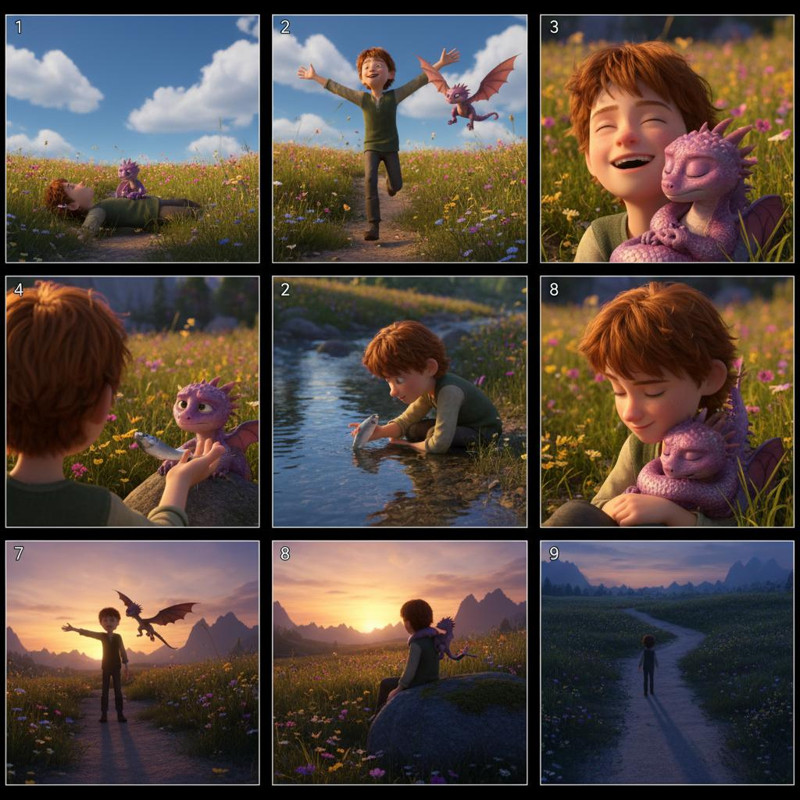

In [10]:
# Generate the 3x3 storyboard
result, session_id = chat_completion(
    prompt=STORYBOARD_PROMPT,
    response_model=StoryboardResponse,
    model="vlmrun-orion-1:auto"
)

print(">> RESPONSE")
print(result)
print(f"\n>> SESSION ID: {session_id}")

# Get the generated storyboard image from artifacts
storyboard_img: Image.Image = client.artifacts.get(session_id=session_id, object_id=result.image.id)
print("\n>> GENERATED STORYBOARD")
display(images=[storyboard_img], texts=["3x3 Storyboard - 9 Sequential Scenes"], width=800)


## Custom Storyboard Generation

You can create your own storyboard by providing a custom prompt. The prompt should follow a similar structure, describing 9 sequential scenes with their positions in the grid.


In [11]:
# Custom storyboard prompt function
def generate_storyboard(
    global_style: str,
    panel_descriptions: list[str],
    technical_notes: str = "3x3 layout, exactly 9 different images."
) -> Image.Image:
    """
    Generate a 3x3 storyboard from scene descriptions.
    
    Args:
        global_style: Global style description for all panels
        panel_descriptions: List of 9 panel descriptions (one for each scene)
        technical_notes: Additional technical instructions
    
    Returns:
        Generated storyboard image
    """
    if len(panel_descriptions) != 9:
        raise ValueError("Must provide exactly 9 panel descriptions")
    
    positions = [
        "Top-Left", "Top-Center", "Top-Right",
        "Middle-Left", "Middle-Center", "Middle-Right",
        "Bottom-Left", "Bottom-Center", "Bottom-Right"
    ]
    
    prompt = "Generate a professional image with 3x3 film storyboard grid, 9 square panels. Each panel is a separate, distinct scene with a black border. Cinematic DreamWorks/Pixar CGI style.\n\n"
    prompt += f"[Global Style]: {global_style}\n\n"
    
    for i, (pos, desc) in enumerate(zip(positions, panel_descriptions), 1):
        prompt += f"Panel {i} [{pos}]: {desc}\n\n"
    
    prompt += f"Technical: {technical_notes}"
    
    result, session_id = chat_completion(
        prompt=prompt,
        response_model=StoryboardResponse,
        model="vlmrun-orion-1:auto"
    )
    
    storyboard_img = client.artifacts.get(session_id=session_id, object_id=result.image.id)
    return storyboard_img, session_id

print("Custom storyboard generation function defined!")


Custom storyboard generation function defined!


>> SESSION ID: db255715-5d8a-4bab-8e21-59d9fc4a5a52

>> CUSTOM STORYBOARD



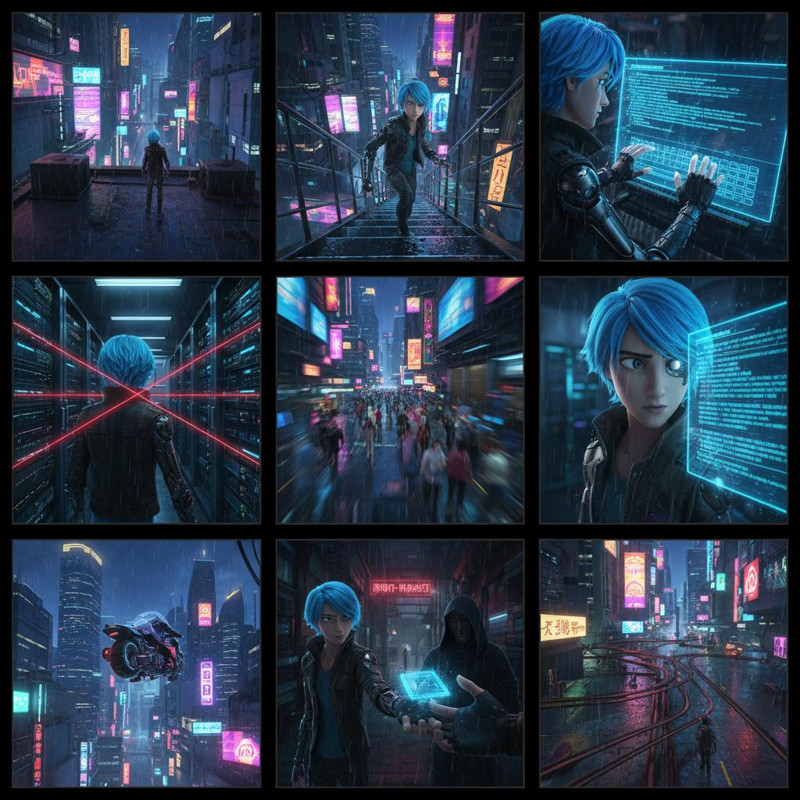

In [12]:
# Example: Generate a custom storyboard
custom_global_style = "Cyberpunk cityscape at night, neon lights, rain-soaked streets, futuristic vehicles. Character: Rogue hacker with neon-blue hair and cybernetic implants."

custom_panels = [
    "WIDE establishing shot. Hacker standing on a rooftop overlooking the neon-lit city, rain falling.",
    "MEDIUM shot. Hacker sliding down a fire escape, neon reflections on wet metal.",
    "CLOSE-UP. Hacker's hand typing on a holographic keyboard, code scrolling across their cybernetic eye.",
    "OVER-SHOULDER shot. Hacker breaking into a corporate server room, security lasers visible.",
    "MEDIUM action shot. Hacker running through crowded streets, neon signs blurring past.",
    "TENDER CLOSE-UP. Hacker's face illuminated by a data stream, showing determination.",
    "WIDE shot. Hacker on a flying motorcycle, weaving between skyscrapers.",
    "TWO-SHOT. Hacker meeting with a contact in a dimly lit alley, exchanging data chip.",
    "WIDE high-angle shot. Hacker disappearing into the city's neon maze, mission complete."
]

custom_storyboard, custom_session_id = generate_storyboard(
    global_style=custom_global_style,
    panel_descriptions=custom_panels
)

print(f">> SESSION ID: {custom_session_id}")
print("\n>> CUSTOM STORYBOARD")
display(images=[custom_storyboard], texts=["Custom Cyberpunk Storyboard"], width=800)


---

## Conclusion

This notebook demonstrated how to use **VLM Run Orion** to generate professional 3x3 storyboard images from story prompts.

### Key Takeaways

1. **Structured Prompts**: Well-structured prompts with global style and individual panel descriptions produce better results.
2. **Session Management**: Use `session_id` to retrieve generated images from artifacts.
3. **Flexible Generation**: Create custom storyboards by providing your own scene descriptions.
4. **Artifact Retrieval**: Generated images are stored as artifacts and can be retrieved using `client.artifacts.get()`.

### Next Steps

- Experiment with different story styles and genres
- Try different cinematic styles (realistic, animated, stylized, etc.)
- Explore the [VLM Run Documentation](https://docs.vlm.run) for more capabilities
- Join our [Discord community](https://discord.gg/AMApC2UzVY) for support

Happy storytelling! 🎬
